In [249]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, round
import time

In [250]:
import findspark
findspark.init(r"D:\Spark\spark-2.4.6-bin-hadoop2.7")

In [251]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('flightDelay').getOrCreate()

In [252]:
airlines_df = spark.read.csv("DelayedFlights-updated.csv", inferSchema=True, header=True)

In [256]:
selected_data = airlines_df.where((col('Dest')=='JFK') & (col('DepDelay') > 100))
#data_all.printSchema()

In [137]:
def get_delay_by_delay_type(airlines_delay_df, delay_types):
    time_by_delay_type = []
    results_all = []
    for item in delay_types:
        start_time = time.time()
        result = (airlines_delay_df
            .where((col("Year") >= 2003) & (col("Year") <= 2010) & (col(item) > 0))
            .groupBy("Year")
            .agg(round(avg(item), 3).alias(f"Average_{item}"))
            .orderBy("Year")
        )
        end_time = time.time()
        results_all.append(result)
        time_by_delay_type.append({f"{item}":end_time - start_time})
    return results_all, time_by_delay_type


In [138]:
delayTypes = ["CarrierDelay", "NASDelay", "WeatherDelay", "LateAircraftDelay", "SecurityDelay"]
delay_by_type, delayTime = get_delay_by_delay_type(airlines_df, delayTypes)
for item in delay_by_type:
    item.show()

+----+--------------------+
|Year|Average_CarrierDelay|
+----+--------------------+
|2003|              58.407|
|2004|              43.915|
|2005|              37.789|
|2006|              37.561|
|2007|              25.137|
|2008|              31.659|
|2009|              29.049|
|2010|              32.129|
+----+--------------------+

+----+----------------+
|Year|Average_NASDelay|
+----+----------------+
|2003|          36.392|
|2004|          13.324|
|2005|          18.889|
|2006|          21.195|
|2007|          36.802|
|2008|          22.381|
|2009|          29.742|
|2010|           33.66|
+----+----------------+

+----+--------------------+
|Year|Average_WeatherDelay|
+----+--------------------+
|2003|                55.0|
|2004|                41.0|
|2005|                26.7|
|2006|                64.0|
|2007|              32.286|
|2008|              38.125|
|2009|                12.0|
|2010|                30.0|
+----+--------------------+

+----+-------------------------+
|Yea

In [141]:
time_list = []
start_time = time.time()
for run in range(1, 6):
    time_per_run,time_by_type  = get_delay_by_delay_type(airlines_df, delayTypes)   
    end_time = time.time()
    time_list.append({f"time_for_run#{run}":end_time - start_time, "by_type":time_by_type})
print(time_list)

[{'time_for_run#1': 0.12800216674804688, 'by_type': [{'CarrierDelay': 0.027999401092529297}, {'NASDelay': 0.023003339767456055}, {'WeatherDelay': 0.023997068405151367}, {'LateAircraftDelay': 0.029000282287597656}, {'SecurityDelay': 0.023003816604614258}]}, {'time_for_run#2': 0.2570052146911621, 'by_type': [{'CarrierDelay': 0.023998022079467773}, {'NASDelay': 0.02500176429748535}, {'WeatherDelay': 0.03400468826293945}, {'LateAircraftDelay': 0.02299952507019043}, {'SecurityDelay': 0.021999359130859375}]}, {'time_for_run#3': 0.3760066032409668, 'by_type': [{'CarrierDelay': 0.02200031280517578}, {'NASDelay': 0.02200031280517578}, {'WeatherDelay': 0.02900075912475586}, {'LateAircraftDelay': 0.023000001907348633}, {'SecurityDelay': 0.02200007438659668}]}, {'time_for_run#4': 0.513002872467041, 'by_type': [{'CarrierDelay': 0.025002241134643555}, {'NASDelay': 0.03300046920776367}, {'WeatherDelay': 0.02399301528930664}, {'LateAircraftDelay': 0.028000354766845703}, {'SecurityDelay': 0.02600097656

In [169]:
CarrierDelay =[]
NASDelay = []
WeatherDelay =[]
LateAircraftDelay =[]
SecurityDelay =[]
for index, item in enumerate(time_list):
    CarrierDelay+=item['by_type'][0].values()
    NASDelay+=item['by_type'][1].values()
    WeatherDelay+=item['by_type'][2].values()
    LateAircraftDelay+=item['by_type'][3].values()
    SecurityDelay+=item['by_type'][4].values()


In [177]:
import pyspark.sql.functions as F
CarrierDelay_avg = F.udf(lambda x: float(np.mean(json.loads(CarrierDelay))), 'float')

In [191]:
from pyspark.sql.functions import avg
from pyspark.sql.types import StructType, StructField, FloatType
def get_average_value(values_list):
    schema_list = StructType([StructField("value", FloatType(), True)])
    values_df = spark.createDataFrame([(value,) for value in values_list], schema_list)
    avg_value = values_df.agg(avg("value")).collect()[0][0]
    return avg_value

In [192]:
CarrierDelay_avg =get_average_value(CarrierDelay)
NASDelay_avg = get_average_value(NASDelay)
WeatherDelay_avg =get_average_value(WeatherDelay)
LateAircraftDelay_avg =get_average_value(LateAircraftDelay)
SecurityDelay_avg =get_average_value(SecurityDelay)

In [193]:
average_time_by_delay_type_values = [CarrierDelay_avg, NASDelay_avg, WeatherDelay_avg, LateAircraftDelay_avg, SecurityDelay_avg]

In [194]:
average_time_by_delay_type_values

[0.03180093765258789,
 0.026001644134521485,
 0.027599096298217773,
 0.025999832153320312,
 0.024800825119018554]

In [196]:
from matplotlib import pyplot as plt
import numpy as np

In [203]:
a = np.array(average_time_by_delay_type_values)

zipped = zip(delayTypes, average_time_by_delay_type_values)
df = pd.DataFrame(zipped, columns=['delay_type', 'average_processing_time'])

In [205]:
df

,delay_type,average_processing_time
0,CarrierDelay,0.031801
1,NASDelay,0.026002
2,WeatherDelay,0.027599
3,LateAircraftDelay,0.026000
4,SecurityDelay,0.024801


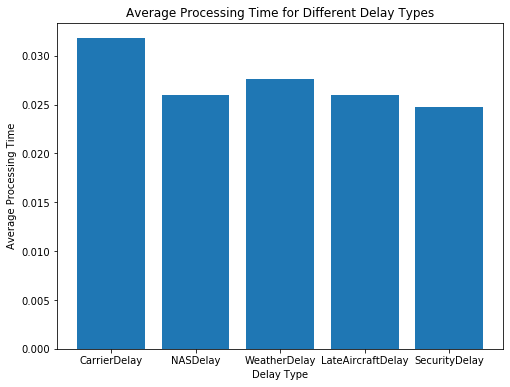

<Figure size 432x288 with 0 Axes>

In [243]:
plt.figure(figsize=(8, 6))
plt.bar(df['delay_type'], df['average_processing_time'])
plt.xlabel('Delay Type')
plt.ylabel('Average Processing Time')
plt.title('Average Processing Time for Different Delay Types')
plt.show()
plt.savefig('average_processing_time.png', dpi=300)

In [244]:
for item in time_list:
    print(item.keys())

dict_keys(['time_for_run#1', 'by_type'])
dict_keys(['time_for_run#2', 'by_type'])
dict_keys(['time_for_run#3', 'by_type'])
dict_keys(['time_for_run#4', 'by_type'])
dict_keys(['time_for_run#5', 'by_type'])


In [245]:
execution_time_per_run_cumulative = [next(iter(d.values())) for d in time_list]

In [246]:
execution_time_per_run_cumulative

[0.12800216674804688,
 0.2570052146911621,
 0.3760066032409668,
 0.513002872467041,
 0.6850087642669678]

In [247]:
a = np.array(average_time_by_delay_type_values)

zipped = zip([f"run#_{x}" for x in range(1, 6)], execution_time_per_run_cumulative)
time_per_run_cumulative = pd.DataFrame(zipped, columns=['run_number', 'cumulative_processing_time'])

In [248]:
time_per_run_cumulative

,run_number,cumulative_processing_time
0,run#_1,0.128002
1,run#_2,0.257005
2,run#_3,0.376007
3,run#_4,0.513003
4,run#_5,0.685009


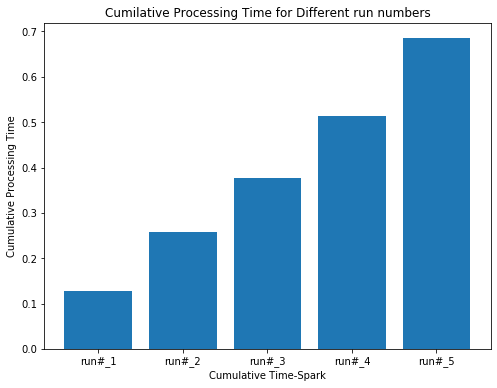

<Figure size 432x288 with 0 Axes>

In [242]:
plt.figure(figsize=(8, 6))
plt.bar(time_per_run_cumulative['run_number'], time_per_run_cumulative['cumulative_processing_time'])
plt.xlabel('Cumulative Time-Spark')
plt.ylabel('Cumulative Processing Time')
plt.title('Cumilative Processing Time for Different run numbers')
plt.show()
plt.savefig('cumulative_processing_time.png', dpi=300)